In [1]:
#в датасетах есть категории которые можно упростить с помощью ранжировки от 1 до N, где N это число которое следует указать ниже
rang_group = 20
#если хотим прогнать все модели и найти лучшие параметры,то указать True
check_all_models = True

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [3]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.columns = train_data.columns.str.lower()
train_data.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.columns = test_data.columns.str.lower()
test_data.head()

,passengerid,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  418 non-null    int64  
 1   pclass       418 non-null    int64  
 2   name         418 non-null    object 
 3   sex          418 non-null    object 
 4   age          332 non-null    float64
 5   sibsp        418 non-null    int64  
 6   parch        418 non-null    int64  
 7   ticket       418 non-null    object 
 8   fare         417 non-null    float64
 9   cabin        91 non-null     object 
 10  embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [7]:
# есть несколько столбоц которые можно объединить в одну категорию - семья
train_data['family'] = train_data['sibsp'] + train_data['parch']
test_data['family'] = test_data['sibsp'] + test_data['parch']

# либо указать, что человек 1 без семьи
train_data['is_alone'] = train_data['family'] == 0
test_data['is_alone'] = test_data['family'] == 0

# в столбце cabin слишком много пропущенных значений - удаляем эти данные, т.к. не сможем восстановить
train_data = train_data.drop(['cabin'], axis=1)
test_data = test_data.drop(['cabin'], axis=1)

In [8]:
#проверим гипотезу по номерам билетов - т.е. чем раньше номер билета тем дальше сажали пассажира, тем самым уменьшая шанс на выживание
train_data['ticket'].unique()

array(['A/5 21171', 'PC 17599', 'STON/O2. 3101282', '113803', '373450',
       '330877', '17463', '349909', '347742', '237736', 'PP 9549',
       '113783', 'A/5. 2151', '347082', '350406', '248706', '382652',
       '244373', '345763', '2649', '239865', '248698', '330923', '113788',
       '347077', '2631', '19950', '330959', '349216', 'PC 17601',
       'PC 17569', '335677', 'C.A. 24579', 'PC 17604', '113789', '2677',
       'A./5. 2152', '345764', '2651', '7546', '11668', '349253',
       'SC/Paris 2123', '330958', 'S.C./A.4. 23567', '370371', '14311',
       '2662', '349237', '3101295', 'A/4. 39886', 'PC 17572', '2926',
       '113509', '19947', 'C.A. 31026', '2697', 'C.A. 34651', 'CA 2144',
       '2669', '113572', '36973', '347088', 'PC 17605', '2661',
       'C.A. 29395', 'S.P. 3464', '3101281', '315151', 'C.A. 33111',
       'S.O.C. 14879', '2680', '1601', '348123', '349208', '374746',
       '248738', '364516', '345767', '345779', '330932', '113059',
       'SO/C 14885', '31012

In [9]:
# оставим только циферные значения
import re
import numpy as np
import pandas as pd

# Пример извлечения и преобразования цифр
def extract_digits(ticket):
    digits = re.findall(r'\d+', ticket)
    return int(''.join(digits)) if digits else np.nan

# Извлечение цифр и конвертация в int
for dataset in [train_data, test_data]:
    dataset['digit_ticket'] = dataset['ticket'].apply(extract_digits)

# Отключаем научную нотацию
np.set_printoptions(suppress=True)

# Проверка уникальных значений
print(train_data['digit_ticket'].unique())
print(test_data['digit_ticket'].unique())

[  521171.    17599. 23101282.   113803.   373450.   330877.    17463.
   349909.   347742.   237736.     9549.   113783.    52151.   347082.
   350406.   248706.   382652.   244373.   345763.     2649.   239865.
   248698.   330923.   113788.   347077.     2631.    19950.   330959.
   349216.    17601.    17569.   335677.    24579.    17604.   113789.
     2677.    52152.   345764.     2651.     7546.    11668.   349253.
     2123.   330958.   423567.   370371.    14311.     2662.   349237.
  3101295.   439886.    17572.     2926.   113509.    19947.    31026.
     2697.    34651.     2144.     2669.   113572.    36973.   347088.
    17605.     2661.    29395.     3464.  3101281.   315151.    33111.
    14879.     2680.     1601.   348123.   349208.   374746.   248738.
   364516.   345767.   345779.   330932.   113059.    14885.  3101278.
     6608.   392086.   343275.   343276.   347466.     5734.     2315.
   364500.   374910.    17754.    17759.   231919.   244367.   349245.
   349

In [10]:
# посмотрим сколько пропусков в датасетах среди номеров билетов
display(train_data['digit_ticket'].isna().sum())
test_data['digit_ticket'].isna().sum()

4

0

In [11]:
#посмотрим почему получились пропуски и видим, что это уникальные билеты для сотрудников White Star Line
train_data[train_data['digit_ticket'].isna() == True]

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked,family,is_alone,digit_ticket
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,S,0,True,NaN
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,S,0,True,NaN
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,S,0,True,NaN
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,S,0,True,NaN


In [12]:
# проверим есть ли такие пассажиры в тестовой базе
test_data[test_data['ticket'] == 'LINE']

,passengerid,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked,family,is_alone,digit_ticket


In [13]:
# т.к. в тестовой базе нет таких пассажиров
# Замена Line на 0 в 'ticket', т.к. это не имеет в большей степени значения
train_data.loc[train_data['ticket'] == 'LINE', ['ticket', 'digit_ticket']] = 0
test_data.loc[test_data['ticket'] == 'LINE', ['ticket', 'digit_ticket']] = 0

In [14]:
# Сделаем категоризацию номеров билетов на основе квантилей и сохранением границ
train_data['digit_ticketband'], bins = pd.qcut(train_data['digit_ticket'], rang_group, retbins=True)

# Вывод средних значений выживаемости по группам
print(train_data[['digit_ticketband', 'survived']].groupby(['digit_ticketband'], as_index=False).mean())

          digit_ticketband  survived
0         (-0.001, 2343.0]  0.352941
1         (2343.0, 2673.0]  0.525000
2         (2673.0, 5063.0]  0.232558
3        (5063.0, 11774.0]  0.355556
4       (11774.0, 17421.0]  0.617021
5       (17421.0, 17604.0]  0.690476
6       (17604.0, 22800.0]  0.636364
7       (22800.0, 31921.0]  0.478261
8       (31921.0, 53567.0]  0.465116
9      (53567.0, 113510.0]  0.422222
10    (113510.0, 228825.0]  0.568182
11    (228825.0, 244278.0]  0.444444
12    (244278.0, 315093.5]  0.386364
13    (315093.5, 345778.0]  0.288889
14    (345778.0, 347465.0]  0.181818
15    (347465.0, 349243.0]  0.111111
16    (349243.0, 364045.0]  0.181818
17    (364045.0, 372622.0]  0.288889
18    (372622.0, 521173.5]  0.204545
19  (521173.5, 23101294.0]  0.266667


<ipython-input-14-6a0e63f1d709>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(train_data[['digit_ticketband', 'survived']].groupby(['digit_ticketband'], as_index=False).mean())


In [15]:
# теория подтвердилась, чем больше число номера билета тем больше был шанс на выживание
# cделаем ранжирование согласно имеющимся рамкам
for dataset in [train_data, test_data]:
    dataset['digit_ticket'] = pd.cut(dataset['digit_ticket'], bins, labels=False, include_lowest=True)

# Вывод первых строк для проверки
display(train_data.head())
display(test_data.head())

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked,family,is_alone,digit_ticket,digit_ticketband
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1,False,18,"(372622.0, 521173.5]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,1,False,5,"(17421.0, 17604.0]"
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0,True,19,"(521173.5, 23101294.0]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,1,False,10,"(113510.0, 228825.0]"
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,0,True,18,"(372622.0, 521173.5]"


,passengerid,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked,family,is_alone,digit_ticket
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,0,True,13
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,1,False,16
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,0,True,11
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,0,True,13
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,2,False,19


In [16]:
# посмотрим пропуски в столбце 'fare' базы test_data
test_data[test_data['fare'].isna() == True]


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,passengerid,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked,family,is_alone,digit_ticket
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,S,0,True,2


In [17]:
# заполним медианой 3 класса палубы и мужского пола
median_test_fare_isna = test_data[(test_data['fare'].isna() == False) & (test_data['pclass'] == 3) & (test_data['sex'] == 'male')]['fare'].median()
test_data['fare'] = test_data['fare'].fillna(median_test_fare_isna)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   passengerid   418 non-null    int64  
 1   pclass        418 non-null    int64  
 2   name          418 non-null    object 
 3   sex           418 non-null    object 
 4   age           332 non-null    float64
 5   sibsp         418 non-null    int64  
 6   parch         418 non-null    int64  
 7   ticket        418 non-null    object 
 8   fare          418 non-null    float64
 9   embarked      418 non-null    object 
 10  family        418 non-null    int64  
 11  is_alone      418 non-null    bool   
 12  digit_ticket  418 non-null    int64  
dtypes: bool(1), float64(2), int64(6), object(4)
memory usage: 39.7+ KB


In [18]:
# категаризируем стоимость билета в обоих базах
# Заполнение пропусков и преобразование в int
for dataset in [train_data, test_data]:
    fare_avg = dataset['fare'].mean()
    fare_std = dataset['fare'].std()
    fare_null_count = dataset['fare'].isnull().sum()
    
    fare_null_random_list = np.random.randint(fare_avg - fare_std, fare_avg + fare_std, size=fare_null_count)
    dataset.loc[np.isnan(dataset['fare']), 'fare'] = fare_null_random_list
    dataset['fare'] = dataset['fare'].astype(int)

# Категоризация стоимости для train_data и сохранение границ
train_data['fareband'], bins = pd.cut(train_data['fare'], rang_group, retbins=True)

# Печать средних значений выживаемости по группам
# 
print(train_data[['fareband', 'survived']].groupby(['fareband'], as_index=False).mean())

          fareband  survived
0   (-0.512, 25.6]  0.286726
1     (25.6, 51.2]  0.429412
2     (51.2, 76.8]  0.593750
3    (76.8, 102.4]  0.769231
4   (102.4, 128.0]  0.733333
5   (128.0, 153.6]  0.750000
6   (153.6, 179.2]  1.000000
7   (179.2, 204.8]       NaN
8   (204.8, 230.4]  0.666667
9   (230.4, 256.0]  0.500000
10  (256.0, 281.6]  0.666667
11  (281.6, 307.2]       NaN
12  (307.2, 332.8]       NaN
13  (332.8, 358.4]       NaN
14  (358.4, 384.0]       NaN
15  (384.0, 409.6]       NaN
16  (409.6, 435.2]       NaN
17  (435.2, 460.8]       NaN
18  (460.8, 486.4]       NaN
19  (486.4, 512.0]  1.000000


<ipython-input-18-db187ec24b8d>:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(train_data[['fareband', 'survived']].groupby(['fareband'], as_index=False).mean())
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [19]:
# Применение той же категоризации на обоих наборах данных
for dataset in [train_data, test_data]:
    dataset['fare'] = pd.cut(dataset['fare'], bins, labels=False, include_lowest=True)

# Вывод первых строк для проверки
display(train_data.head())
display(test_data.head())

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked,family,is_alone,digit_ticket,digit_ticketband,fareband
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,0,S,1,False,18,"(372622.0, 521173.5]","(-0.512, 25.6]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,2,C,1,False,5,"(17421.0, 17604.0]","(51.2, 76.8]"
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,0,S,0,True,19,"(521173.5, 23101294.0]","(-0.512, 25.6]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,2,S,1,False,10,"(113510.0, 228825.0]","(51.2, 76.8]"
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,0,S,0,True,18,"(372622.0, 521173.5]","(-0.512, 25.6]"


,passengerid,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked,family,is_alone,digit_ticket
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,0,Q,0,True,13
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,0,S,1,False,16
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,0,Q,0,True,11
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,0,S,0,True,13
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,0,S,2,False,19


In [20]:
# Обработка возраста и категоризация
for dataset in [train_data, test_data]:
    # Заполнение пропущенных значений
    age_avg = dataset['age'].mean()
    age_std = dataset['age'].std()
    age_null_count = dataset['age'].isnull().sum()
    
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset.loc[np.isnan(dataset['age']), 'age'] = age_null_random_list
    dataset['age'] = dataset['age'].astype(int)

# Автоматическое определение границ
train_data['ageband'], bins = pd.cut(train_data['age'], rang_group, retbins=True)

# Вывод средних значений выживаемости по группам
print(train_data[['ageband', 'survived']].groupby(['ageband'], as_index=False).mean())

         ageband  survived
0   (-0.08, 4.0]  0.675000
1     (4.0, 8.0]  0.642857
2    (8.0, 12.0]  0.266667
3   (12.0, 16.0]  0.444444
4   (16.0, 20.0]  0.336449
5   (20.0, 24.0]  0.358333
6   (24.0, 28.0]  0.336538
7   (28.0, 32.0]  0.373832
8   (32.0, 36.0]  0.432990
9   (36.0, 40.0]  0.333333
10  (40.0, 44.0]  0.346154
11  (44.0, 48.0]  0.342857
12  (48.0, 52.0]  0.482759
13  (52.0, 56.0]  0.437500
14  (56.0, 60.0]  0.384615
15  (60.0, 64.0]  0.363636
16  (64.0, 68.0]  0.000000
17  (68.0, 72.0]  0.000000
18  (72.0, 76.0]  0.000000
19  (76.0, 80.0]  1.000000


<ipython-input-20-244831d3bebc>:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(train_data[['ageband', 'survived']].groupby(['ageband'], as_index=False).mean())


Этот метод заполнения пропусков в данных считается оптимальным по нескольким причинам:

1) Сохранение распределения данных: Заполнение пропусков случайными значениями из интервала, который определен средним значением и стандартным отклонением, помогает сохранить исходное распределение данных. Это важно, потому что многие статистические тесты и модели машинного обучения предполагают, что данные распределены определенным образом.

2) Простота и гибкость: Этот метод не требует сложных вычислений или предположений. Он может быть легко адаптирован для различных наборов данных и различных типов пропущенных значений.

3) Минимизация искажения данных: Заполнение пропусков средним значением или медианой может исказить распределение данных, особенно если пропусков много. Этот метод минимизирует такое искажение.

In [21]:
# Применение той же категоризации на обоих наборах данных
for dataset in [train_data, test_data]:
    # Используем bins из train_data для постоянства
    dataset['age'] = pd.cut(dataset['age'], bins, labels=False, include_lowest=True)

# Вывод первых строк для проверки
display(train_data.head())
display(test_data.head())

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked,family,is_alone,digit_ticket,digit_ticketband,fareband,ageband
0,1,0,3,"Braund, Mr. Owen Harris",male,5,1,0,A/5 21171,0,S,1,False,18,"(372622.0, 521173.5]","(-0.512, 25.6]","(20.0, 24.0]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,9,1,0,PC 17599,2,C,1,False,5,"(17421.0, 17604.0]","(51.2, 76.8]","(36.0, 40.0]"
2,3,1,3,"Heikkinen, Miss. Laina",female,6,0,0,STON/O2. 3101282,0,S,0,True,19,"(521173.5, 23101294.0]","(-0.512, 25.6]","(24.0, 28.0]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,8,1,0,113803,2,S,1,False,10,"(113510.0, 228825.0]","(51.2, 76.8]","(32.0, 36.0]"
4,5,0,3,"Allen, Mr. William Henry",male,8,0,0,373450,0,S,0,True,18,"(372622.0, 521173.5]","(-0.512, 25.6]","(32.0, 36.0]"


,passengerid,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked,family,is_alone,digit_ticket
0,892,3,"Kelly, Mr. James",male,8,0,0,330911,0,Q,0,True,13
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,11,1,0,363272,0,S,1,False,16
2,894,2,"Myles, Mr. Thomas Francis",male,15,0,0,240276,0,Q,0,True,11
3,895,3,"Wirz, Mr. Albert",male,6,0,0,315154,0,S,0,True,13
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,5,1,1,3101298,0,S,2,False,19


In [22]:
# меняем male на 1 а female на 2
def map_sex(value):
    if value == 'male':
        return 0
    elif value == 'female':
        return 1
    else:
        return value

train_data['sex'] = train_data['sex'].apply(map_sex)
test_data['sex'] = test_data['sex'].apply(map_sex)

display(train_data['sex'].unique())
test_data['sex'].unique()

array([0, 1])

array([0, 1])

In [23]:
# меняет аналогично пункты отбытия
def map_embarked(value):
    if value == 'S':
        return 0
    elif value == 'C':
        return 1
    else:
        return 2

train_data['embarked'] = train_data['embarked'].apply(map_embarked)
test_data['embarked'] = test_data['embarked'].apply(map_embarked)

display(train_data['embarked'].unique())
test_data['embarked'].unique()

array([0, 1, 2])

array([2, 0, 1])

In [24]:
#обработаем обращения к пассажирам
for dataset in [train_data, test_data]:
    dataset['title'] = dataset.name.str.extract(' ([A-Za-z]+)\.')
train_data['title'].unique()


array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

1) 'Mr': Мужчины
2) 'Mrs': Замужние женщины
3) 'Miss': Незамужние женщины или девочки
4) 'Master': Мальчики
5) 'Don', 'Sir', 'Major', 'Col', 'Capt', 'Jonkheer': Обычно обозначают мужчин, часто с определенным социальным статусом или воинским званием
6) 'Rev', 'Dr': Обычно обозначают мужчин с религиозным или академическим званием, хотя эти титулы могут быть присвоены и женщинам
7) 'Mme', 'Ms', 'Lady', 'Countess': Обычно обозначают женщин, часто с определенным социальным статусом
8) 'Mlle': Незамужние женщины во французском (аналог 'Miss')

Сделаем такие категории:
1) Mr, Don, Sir, Major, Col, Capt, Jonkheer
2) Mrs
3) Miss, Mlle, Master
4) Rev, Dr
5) Mme, Ms, Lady, Countess

In [25]:
# Замена титулов на более общие категории
for dataset in [train_data, test_data]:
    dataset['title'] = dataset['title'].replace(['Don', 'Sir', 'Major', 'Col', 'Capt', 'Jonkheer', 'Mr'], 'Mr')
    dataset['title'] = dataset['title'].replace(['Mlle', 'Miss'], 'Miss')
    dataset['title'] = dataset['title'].replace(['Mme', 'Ms', 'Lady', 'Countess', 'Mrs'], 'Mrs')
    dataset['title'] = dataset['title'].replace(['Rev', 'Dr'], 'Clergy/academic')
    dataset['title'] = dataset['title'].replace('Master', 'Master')

# Проверка распределения выживаемости по группам
print(train_data[['title', 'survived']].groupby(['title'], as_index=False).mean())

# Преобразование титулов в числовые значения
title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, "Master": 3, "Clergy/academic": 4}
for dataset in [train_data, test_data]:
    dataset['title'] = dataset['title'].map(title_mapping)
    dataset['title'] = dataset['title'].fillna(0)

             title  survived
0  Clergy/academic  0.230769
1           Master  0.575000
2             Miss  0.701087
3               Mr  0.160000
4              Mrs  0.798450


In [26]:
# Определяем столбцы для удаления, которые нам не пригодятся в обучении моделей
train_drop = ['name', 'sibsp', 'parch', 'passengerid', 'ageband', 'fareband', 'ticket', 'digit_ticketband']
test_drop = ['name', 'sibsp', 'parch', 'ticket']

# Удаляем столбцы
train_data.drop(columns=train_drop, inplace=True)
test_data.drop(columns=test_drop, inplace=True)

In [27]:
# посмотрим на итоговые данные
display(train_data.head())
test_data.head()

,survived,pclass,sex,age,fare,embarked,family,is_alone,digit_ticket,title
0,0,3,0,5,0,0,1,False,18,0
1,1,1,1,9,2,1,1,False,5,2
2,1,3,1,6,0,0,0,True,19,1
3,1,1,1,8,2,0,1,False,10,2
4,0,3,0,8,0,0,0,True,18,0


,passengerid,pclass,sex,age,fare,embarked,family,is_alone,digit_ticket,title
0,892,3,0,8,0,2,0,True,13,0.0
1,893,3,1,11,0,0,1,False,16,2.0
2,894,2,0,15,0,2,0,True,11,0.0
3,895,3,0,6,0,0,0,True,13,0.0
4,896,3,1,5,0,0,2,False,19,2.0


In [28]:
#переходим к моделям, приведем размерность датасетов к одному
X_train = train_data.drop('survived', axis=1)
y_train = train_data['survived']

X_test = test_data.drop("passengerid", axis=1).copy()

X_train.shape, y_train.shape, X_test.shape

((891, 9), (891,), (418, 9))

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [30]:
# Разделение X_train и y_train на обучающие и тестовые наборы
t_size = 0.2
r_state = 42
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size=0.1, random_state=r_state)

# в словарь будем записывать модель и ее параметры, которые выдают лучшее качество
results = {}

In [31]:
# Логистическая регрессия
if check_all_models == True:
    model = LogisticRegression()
    model.fit(X_train_split, y_train_split)
    y_pred_log_reg = model.predict(X_test_split)
    
    # Вычисление точности
    acc_log_reg = round(model.score(X_test_split, y_test_split) * 100, 2)
    print(f"Accuracy: {acc_log_reg}%")
    results['LogisticRegression'] = {'best_accuracy': acc_log_reg, 'best_params': None}

Accuracy: 82.22%


In [32]:
# Support Vector Machine (SVM)
if check_all_models == True:
    model = SVC()
    model.fit(X_train_split, y_train_split)
    y_pred_svc = model.predict(X_test_split)
    
    # Вычисление точности
    acc_svc = round(model.score(X_test_split, y_test_split) * 100, 2)
    print(f"Accuracy: {acc_svc}%")
    results['SVC'] = {'best_accuracy': acc_svc, 'best_params': None}

Accuracy: 82.22%


In [33]:
# Линейный SVM
if check_all_models == True:
    model = LinearSVC()
    model.fit(X_train_split, y_train_split)
    y_pred_linear_svc = model.predict(X_test_split)
    
    # Вычисление точности
    acc_linear_svc = round(model.score(X_test_split, y_test_split) * 100, 2)
    print(f"Accuracy: {acc_linear_svc}%")
    results['LinearSVC'] = {'best_accuracy': acc_linear_svc, 'best_params': None}

Accuracy: 82.22%


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [34]:
# Решающие деревья
if check_all_models == True:
    model = DecisionTreeClassifier()
    model.fit(X_train_split, y_train_split)
    y_pred_decision_tree = model.predict(X_test_split)
    
    # Вычисление точности
    acc_decision_tree = round(model.score(X_test_split, y_test_split) * 100, 2)
    print(f"Accuracy: {acc_decision_tree}%")
    results['DecisionTreeClassifier'] = {'best_accuracy': acc_decision_tree, 'best_params': None}

Accuracy: 81.11%


In [35]:
# Gaussian Naive Bayes
if check_all_models == True:
    model = GaussianNB()
    model.fit(X_train_split, y_train_split)
    y_pred_gnb = model.predict(X_test_split)
    
    # Вычисление точности
    acc_gnb = round(model.score(X_test_split, y_test_split) * 100, 2)
    print(f"Accuracy: {acc_gnb}%")
    results['GaussianNB'] = {'best_accuracy': acc_gnb, 'best_params': None}

Accuracy: 82.22%


In [36]:
# k-ближайших соседей (KNeighborsClassifier) с подбором лучшего k
if check_all_models == True:
    best_accuracy = 0
    best_k = 0
    
    for k in range(5, 20):
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train_split, y_train_split)
        acc_knn = round(model.score(X_test_split, y_test_split) * 100, 2)
        if acc_knn > best_accuracy:
            best_accuracy = acc_knn
            best_k = k
    
    print("Best accuracy is " + str(best_accuracy) + "% with n_neighbors = " + str(best_k))
    results['KNeighborsClassifier'] = {'best_accuracy': best_accuracy, 'best_params': {'n_neighbors': best_k}}

Best accuracy is 76.67% with n_neighbors = 8


In [37]:
# Перцептрон (Perceptron) с подбором лучшего max_iter
if check_all_models == True:
    best_accuracy = 0
    best_iter = 0
    
    for i in range(2, 100):
        model = Perceptron(max_iter=i, tol=None, random_state=r_state)
        model.fit(X_train_split, y_train_split)
        acc_perceptron = round(model.score(X_test_split, y_test_split) * 100, 2)
        if acc_perceptron > best_accuracy:
            best_accuracy = acc_perceptron
            best_iter = i
    
    print("Best accuracy is " + str(best_accuracy) + "% with max_iter = " + str(best_iter))
    results['Perceptron'] = {'best_accuracy': best_accuracy, 'best_params': {'max_iter': best_iter}}

Best accuracy is 87.78% with max_iter = 93


In [38]:
# Стохастический градиентный спуск (SGD) с подбором лучшего max_iter
if check_all_models == True:
    best_accuracy = 0
    best_iter = 0
    
    for i in range(2, 100):
        model = SGDClassifier(max_iter=i, tol=None, random_state=r_state)
        model.fit(X_train_split, y_train_split)
        acc_sgd = round(model.score(X_test_split, y_test_split) * 100, 2)
        if acc_sgd > best_accuracy:
            best_accuracy = acc_sgd
            best_iter = i
    
    print("Best accuracy is " + str(best_accuracy) + "% with max_iter = " + str(best_iter))
    results['SGDClassifier'] = {'best_accuracy': best_accuracy, 'best_params': {'max_iter': best_iter}}

Best accuracy is 87.78% with max_iter = 93


In [39]:
# Случайный лес (RandomForestClassifier) с подбором лучших гиперпараметров
if check_all_models == True:
    best_accuracy = 0
    best_n = 0
    best_max_depth = 0
    
    # Определение гиперпараметров
    param_grid = {
        'n_estimators': range(15, 20),
        'max_depth': range(1, 10)
    }
    
    # Создание модели
    model = RandomForestClassifier(random_state=r_state)
    
    # Инициализация GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
    
    # Обучение модели
    grid_search.fit(X_train_split, y_train_split)
    
    # Получение лучших параметров
    best_params = grid_search.best_params_
    acc_random_forest = best_accuracy
    acc_random_forest = round(grid_search.best_score_ * 100, 2)
    
    print(f"Best accuracy is {acc_random_forest}% with n_estimators = {best_params['n_estimators']}, max_depth = {best_params['max_depth']}")
    results['RandomForestClassifier'] = {'best_accuracy': acc_random_forest, 'best_params': best_params}

Best accuracy is 83.02% with n_estimators = 17, max_depth = 5


In [40]:
# CatBoostClassifier с подбором лучших гиперпараметров
# Определение гиперпараметров
if check_all_models == True:
    param_grid = {
        'iterations': range(1, 16),
        'depth': range(1, 16),
        'learning_rate': np.arange(0.3, 0.5, 0.05)
    }
    
    # Создание модели
    model = CatBoostClassifier(random_seed=r_state, verbose=False)
    
    # Инициализация GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
    
    # Обучение модели
    grid_search.fit(X_train_split, y_train_split)
    
    # Получение лучших параметров
    best_params = grid_search.best_params_
    acc_catboost = best_accuracy
    acc_catboost = round(grid_search.best_score_ * 100, 2)
    
    print(f"Best accuracy is {acc_catboost}% with iterations = {best_params['iterations']}, depth = {best_params['depth']} and learning_rate = {best_params['learning_rate']}")
    results['CatBoostClassifier'] = {'best_accuracy': acc_catboost, 'best_params': best_params}

Best accuracy is 84.02% with iterations = 15, depth = 5 and learning_rate = 0.44999999999999996


In [41]:
# Gradient Boosting Classifier с подбором лучших гиперпараметров
# Определение гиперпараметров
if check_all_models == True:
    param_grid = {
        'n_estimators': range(15, 20),
        'learning_rate': np.arange(0.3, 0.6, 0.05),
        'max_depth': range(1, 5)
    }
    
    # Создание модели
    model = GradientBoostingClassifier(random_state=r_state)
    
    # Инициализация GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
    
    # Обучение модели
    grid_search.fit(X_train_split, y_train_split)
    
    # Получение лучших параметров
    best_params = grid_search.best_params_
    acc_gbc = best_accuracy
    acc_gbc = round(grid_search.best_score_ * 100, 2)
    
    print(f"Best accuracy is {acc_gbc}% with n_estimators = {best_params['n_estimators']}, learning_rate = {best_params['learning_rate']} and max_depth = {best_params['max_depth']}")
    results['GradientBoostingClassifier'] = {'best_accuracy': acc_gbc, 'best_params': best_params}

Best accuracy is 83.65% with n_estimators = 17, learning_rate = 0.3 and max_depth = 3


In [42]:
# XGBoost с подбором лучших гиперпараметров
if check_all_models == True:
    import xgboost as xgb
        
    # Определение гиперпараметров
    param_grid = {
        'n_estimators': range(15, 20),
        'learning_rate': np.arange(0.5, 0.9, 0.05),
        'max_depth': range(1, 5)
    }
    
    # Создание модели
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=r_state)
    
    # Инициализация GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
    
    # Обучение модели
    grid_search.fit(X_train_split, y_train_split)
    
    # Получение лучших параметров
    best_params = grid_search.best_params_
    acc_xgb = best_accuracy
    acc_xgb = round(grid_search.best_score_ * 100, 2)
    
    print(f"Best accuracy is {acc_xgb}% with n_estimators = {best_params['n_estimators']}, learning_rate = {best_params['learning_rate']} and max_depth = {best_params['max_depth']}")
    results['XGBClassifier'] = {'best_accuracy': acc_xgb, 'best_params': best_params}

Best accuracy is 82.77% with n_estimators = 18, learning_rate = 0.5 and max_depth = 3


In [43]:
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Input
# from keras.utils import to_categorical
# from keras.optimizers import Adam
# from keras.callbacks import EarlyStopping
# import numpy as np

# if check_all_models == True:
#     # Конвертация целевой переменной в категориальный формат
#     X_train_split = X_train_split.astype('float32')
#     X_test_split = X_test_split.astype('float32')
#     y_train_cat = to_categorical(y_train_split)
    
#     # Инициализация переменных для поиска лучшей точности
#     best_accuracy_tf = 0
#     best_params = {}
    
#     # Определение обратного вызова EarlyStopping
#     early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
#     # Перебор гиперпараметров
#     for batch_size in range(32, 128, 32):
#         for learning_rate in np.arange(0.1, 0.2, 0.05):
#             for dropout in np.arange(0.04, 0.1, 0.01):
#                 # Создание модели
#                 model = Sequential()
#                 model.add(Input(shape=(X_train_split.shape[1],)))
#                 model.add(Dense(64, activation='relu'))
#                 model.add(Dropout(dropout))
#                 model.add(Dense(32, activation='relu'))
#                 model.add(Dropout(dropout))
#                 model.add(Dense(16, activation='relu'))
#                 model.add(Dropout(dropout))
#                 model.add(Dense(y_train_cat.shape[1], activation='softmax'))
                
#                 opt = Adam(learning_rate=learning_rate)
#                 model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
#                 # Обучение модели с использованием EarlyStopping
#                 history = model.fit(
#                     X_train_split, 
#                     y_train_cat, 
#                     epochs=50, 
#                     batch_size=batch_size, 
#                     validation_data=(X_test_split, to_categorical(y_test_split)),
#                     callbacks=[early_stopping],
#                     verbose=0
#                 )
    
#                 # Получение финальной точности
#                 acc_tf = round(history.history['val_accuracy'][-1] * 100, 2)
#                 print(f"Batch Size: {batch_size}, Learning Rate: {learning_rate}, Dropout: {dropout}, Accuracy: {acc_tf} percent")
    
#                 # Проверка на лучшую точность
#                 if acc_tf > best_accuracy_tf:
#                     best_accuracy_tf = acc_tf
#                     best_params = {'batch_size': batch_size, 'learning_rate': learning_rate, 'dropout': dropout}
    
#     # Вывод лучших параметров и точности
#     print(f"Best Accuracy: {best_accuracy_tf}% with parameters: {best_params}")
#     results['KerasClassifier'] = {'best_accuracy': best_accuracy_tf, 'best_params': best_params}

In [44]:
#остортируем результаты и посмотрим на лучшие гиперпараметры
if check_all_models == True:
    sorted_results = sorted(results.items(), key=lambda x: x[1]['best_accuracy'], reverse=True)
    for model, info in sorted_results:
        print(f"Model: {model}, Best Accuracy: {info['best_accuracy']} percent, Best Parameters: {info['best_params']}")

Model: Perceptron, Best Accuracy: 87.78 percent, Best Parameters: {'max_iter': 93}
Model: SGDClassifier, Best Accuracy: 87.78 percent, Best Parameters: {'max_iter': 93}
Model: CatBoostClassifier, Best Accuracy: 84.02 percent, Best Parameters: {'depth': 5, 'iterations': 15, 'learning_rate': 0.44999999999999996}
Model: GradientBoostingClassifier, Best Accuracy: 83.65 percent, Best Parameters: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 17}
Model: RandomForestClassifier, Best Accuracy: 83.02 percent, Best Parameters: {'max_depth': 5, 'n_estimators': 17}
Model: XGBClassifier, Best Accuracy: 82.77 percent, Best Parameters: {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 18}
Model: LogisticRegression, Best Accuracy: 82.22 percent, Best Parameters: None
Model: SVC, Best Accuracy: 82.22 percent, Best Parameters: None
Model: LinearSVC, Best Accuracy: 82.22 percent, Best Parameters: None
Model: GaussianNB, Best Accuracy: 82.22 percent, Best Parameters: None
Model: DecisionTreeC

Accuracy: 78.11 %


<Axes: >

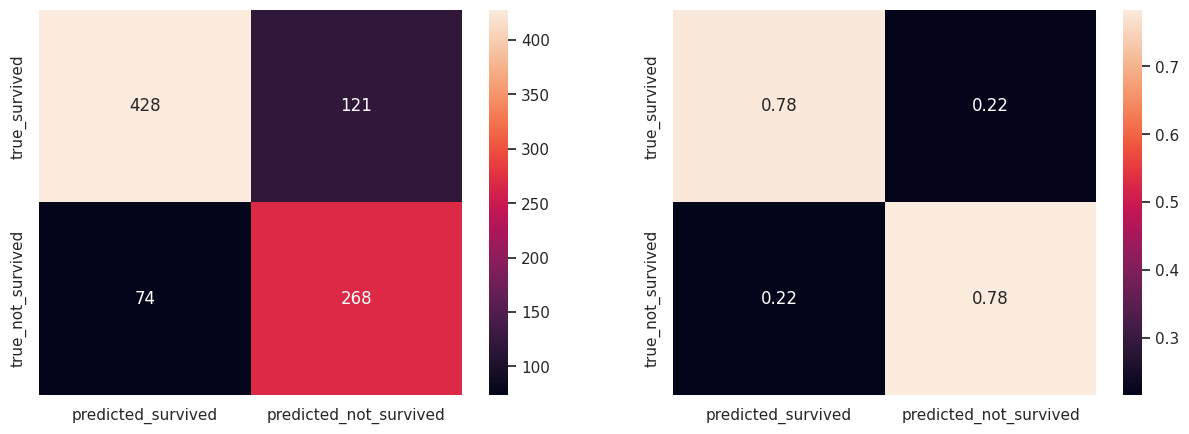

In [45]:
#Матрица неточностей/ошибок (confusion matrix) по лучшей моделе
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
sns.set()

# Словарь, отображающий имя модели на её класс
model_dict = {
    'LogisticRegression': LogisticRegression,
    'SVC': SVC,
    'KNeighborsClassifier': KNeighborsClassifier,
    'DecisionTreeClassifier': DecisionTreeClassifier,
    'RandomForestClassifier': RandomForestClassifier,
    'GaussianNB': GaussianNB,
    'Perceptron': Perceptron,
    'SGDClassifier': SGDClassifier,
    'GradientBoostingClassifier': GradientBoostingClassifier,
    'CatBoostClassifier': CatBoostClassifier,
    'XGBClassifier': XGBClassifier  # Замените на вашу функцию для создания модели Keras
}

if check_all_models == False:
    model_name = "SGDClassifier"
    best_params = {'max_iter': 51}
    results = {}
    results[model_name] = {'best_params': best_params, 'best_accuracy': 0.9}  # Предположим, что лучшая точность составила 90%


# Получение лучшей модели и её параметров
best_model_name, best_model_info = max(results.items(), key=lambda x: x[1]['best_accuracy'])
best_model_class = model_dict[best_model_name]
best_params = best_model_info['best_params']

# Создание экземпляра лучшей модели с лучшими параметрами
model = best_model_class(**best_params)

# Обучение модели и вывод результатов
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
acc = round(model.score(X_train, y_train) * 100, 2)
print(f"Accuracy: {acc} %")

class_names = ['survived', 'not_survived']

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_train, y_pred)

cnf_matrix_percent = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]


true_class_names = ['true_survived', 'true_not_survived']
predicted_class_names = ['predicted_survived', 'predicted_not_survived']

df_cnf_matrix = pd.DataFrame(cnf_matrix, 
                             index = true_class_names,
                             columns = predicted_class_names)

df_cnf_matrix_percent = pd.DataFrame(cnf_matrix_percent, 
                                     index = true_class_names,
                                     columns = predicted_class_names)

plt.figure(figsize = (15,5))

plt.subplot(121)
sns.heatmap(df_cnf_matrix, annot=True, fmt='d')

plt.subplot(122)
sns.heatmap(df_cnf_matrix_percent, annot=True)

In [46]:
# Извлечение значений из матрицы ошибок
tp = cnf_matrix[0, 0]  # True positives (правильно предсказано survived)
fn = cnf_matrix[0, 1]  # False negatives (неправильно предсказано not_survived как survived)
fp = cnf_matrix[1, 0]  # False positives (неправильно предсказано survived как not_survived)
tn = cnf_matrix[1, 1]  # True negatives (правильно предсказано not_survived)

# Вычисление относительных значений
total_survived = tp + fn
total_not_survived = fp + tn

accuracy_survived = tp / total_survived
error_survived = fn / total_survived
error_not_survived = fp / total_not_survived
accuracy_not_survived = tn / total_not_survived

# Формирование текста
description = f"""
## На изображении показаны две матрицы ошибок (confusion matrix) для классификации:

### Левая матрица (в абсолютных значениях):
- {tp}: Правильно предсказано survived (истинно положительные).
- {fn}: Неправильно предсказано not_survived как survived (ложные отрицательные).
- {fp}: Неправильно предсказано survived как not_survived (ложные положительные).
- {tn}: Правильно предсказано not_survived (истинно отрицательные).

### Правая матрица (в относительных значениях):
- {accuracy_survived:.2f}: Доля правильных предсказаний survived.
- {error_survived:.3f}: Доля ошибок, когда survived предсказано как not_survived.
- {error_not_survived:.2f}: Доля ошибок, когда not_survived предсказано как survived.
- {accuracy_not_survived:.2f}: Доля правильных предсказаний not_survived.
"""

print(description)


## На изображении показаны две матрицы ошибок (confusion matrix) для классификации:

### Левая матрица (в абсолютных значениях):
- 428: Правильно предсказано survived (истинно положительные).
- 121: Неправильно предсказано not_survived как survived (ложные отрицательные).
- 74: Неправильно предсказано survived как not_survived (ложные положительные).
- 268: Правильно предсказано not_survived (истинно отрицательные).

### Правая матрица (в относительных значениях):
- 0.78: Доля правильных предсказаний survived.
- 0.220: Доля ошибок, когда survived предсказано как not_survived.
- 0.22: Доля ошибок, когда not_survived предсказано как survived.
- 0.78: Доля правильных предсказаний not_survived.



In [47]:
# Подготовка данных
features = X_train.columns.tolist()
X_test = test_data[features]
predictions = model.predict(X_test)

# Сохранение предсказаний в CSV файл
output = pd.DataFrame({'PassengerId': test_data.passengerid, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
